In [2]:
import pandas as pd
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
import os
import numpy as np

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel



import matplotlib.font_manager	
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.expand_frame_repr', False)


c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [3]:
def twd97_to_lonlat(x=174458.0,y=2525824.0):
    """
    Parameters
    ----------
    x : float
        TWD97 coord system. The default is 174458.0.
    y : float
        TWD97 coord system. The default is 2525824.0.
    Returns
    -------
    list
        [longitude, latitude]
    """
    
    a = 6378137
    b = 6356752.314245
    long_0 = 121 * math.pi / 180.0
    k0 = 0.9999
    dx = 250000
    dy = 0
    
    e = math.pow((1-math.pow(b, 2)/math.pow(a,2)), 0.5)
    
    x -= dx
    y -= dy
    
    M = y / k0
    
    mu = M / ( a*(1-math.pow(e, 2)/4 - 3*math.pow(e,4)/64 - 5 * math.pow(e, 6)/256))
    e1 = (1.0 - pow((1   - pow(e, 2)), 0.5)) / (1.0 +math.pow((1.0 -math.pow(e,2)), 0.5))
    
    j1 = 3*e1/2-27*math.pow(e1,3)/32
    j2 = 21 * math.pow(e1,2)/16 - 55 * math.pow(e1, 4)/32
    j3 = 151 * math.pow(e1, 3)/96
    j4 = 1097 * math.pow(e1, 4)/512
    
    fp = mu + j1 * math.sin(2*mu) + j2 * math.sin(4* mu) + j3 * math.sin(6*mu) + j4 * math.sin(8* mu)
    
    e2 = math.pow((e*a/b),2)
    c1 = math.pow(e2*math.cos(fp),2)
    t1 = math.pow(math.tan(fp),2)
    r1 = a * (1-math.pow(e,2)) / math.pow( (1-math.pow(e,2)* math.pow(math.sin(fp),2)), (3/2))
    n1 = a / math.pow((1-math.pow(e,2)*math.pow(math.sin(fp),2)),0.5)
    d = x / (n1*k0)
    
    q1 = n1* math.tan(fp) / r1
    q2 = math.pow(d,2)/2
    q3 = ( 5 + 3 * t1 + 10 * c1 - 4 * math.pow(c1,2) - 9 * e2 ) * math.pow(d,4)/24
    q4 = (61 + 90 * t1 + 298 * c1 + 45 * math.pow(t1,2) - 3 * math.pow(c1,2) - 252 * e2) * math.pow(d,6)/720
    lat = fp - q1 * (q2 - q3 + q4)
    
    
    q5 = d
    q6 = (1+2*t1+c1) * math.pow(d,3) / 6
    q7 = (5 - 2 * c1 + 28 * t1 - 3 * math.pow(c1,2) + 8 * e2 + 24 * math.pow(t1,2)) * math.pow(d,5) / 120
    lon = long_0 + (q5 - q6 + q7) / math.cos(fp)
    
    lat = (lat*180) / math.pi
    lon = (lon*180) / math.pi
    return [lon, lat]

In [4]:
zip_file_path = "30_Training Dataset_V2.zip"
target_csv_file = "training_data.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        train = pd.read_csv(csv_path)

zip_file_path = "30_Public Dataset_Public Sumission Template_v2.zip"
target_csv_file = "public_dataset.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        test = pd.read_csv(csv_path)

---

In [5]:
#Drop the outlier
train = train[train["ID"] != 'TR-5660']

In [6]:
train['縣市_鄉鎮市區_路名'] = train['縣市'] + '_' + train['鄉鎮市區'] + '_' + train['路名'] 
test['縣市_鄉鎮市區_路名'] = test['縣市'] + '_' + test['鄉鎮市區'] + '_' + test['路名'] 

In [7]:
len(train['縣市_鄉鎮市區_路名'].unique())

3752

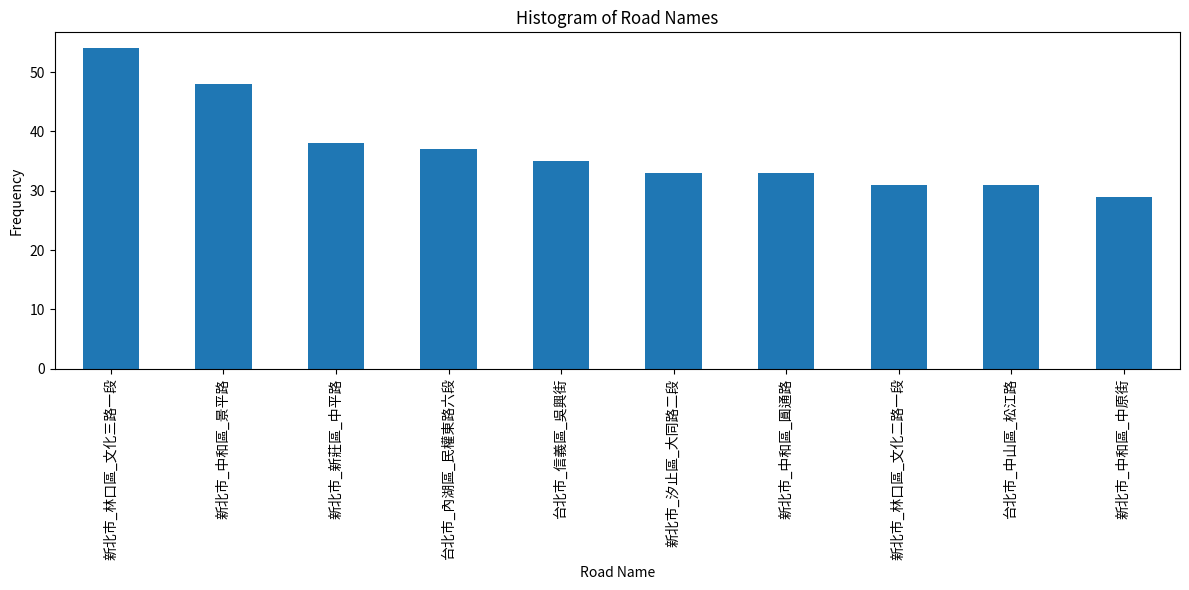

In [8]:
road_names = train['縣市_鄉鎮市區_路名']

# Count the occurrences of each unique road name
road_name_counts = road_names.value_counts()

# Create a bar plot (histogram)
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
road_name_counts.head(10).plot(kind="bar")
plt.title("Histogram of Road Names")
plt.xlabel("Road Name")
plt.ylabel("Frequency")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Ensure all labels are visible

# Show the plot
plt.show()

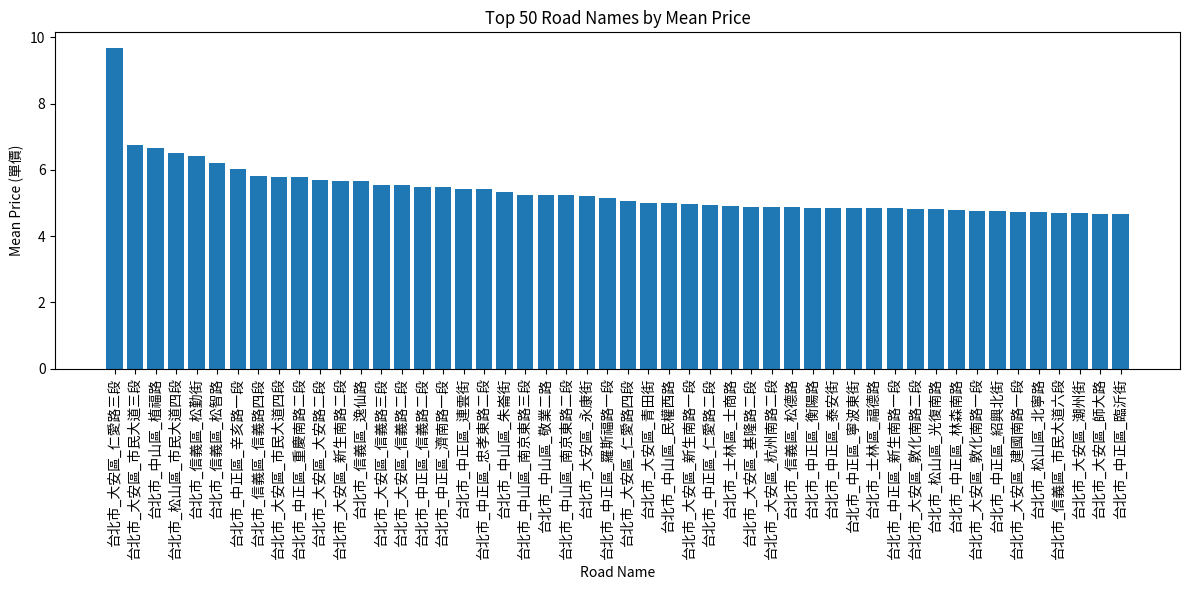

In [9]:
mean_prices_by_road = train.groupby("縣市_鄉鎮市區_路名")["單價"].mean().reset_index()

# Sort the data by mean price in descending order to identify the top categories
mean_prices_by_road = mean_prices_by_road.sort_values(by="單價", ascending=False)

# Plot the top N categories by mean price
N = 50  # You can adjust N as needed
plt.figure(figsize=(12, 6))
plt.bar(mean_prices_by_road["縣市_鄉鎮市區_路名"][:N], mean_prices_by_road["單價"][:N])
plt.title("Top {} Road Names by Mean Price".format(N))
plt.xlabel("Road Name")
plt.ylabel("Mean Price (單價)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()








In [10]:
import category_encoders as ce 

target = train[["單價"]]
train = train.drop('單價', axis=1)
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

In [11]:
train_cbe

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名
0,1.992353,3.395266,4.517230,4.639405,-0.256716,1.983921,11,11,1.996461,1.942214,1.993253,32.583333,-0.174154,-0.819326,0.0,305266,2768378,1.995985,0.393926,0.183700,-0.438452,4.639405
1,1.992353,3.395266,2.517904,2.018249,0.100134,1.983921,7,12,1.996461,1.942214,1.993253,24.166667,0.314204,-0.819326,0.0,300677,2767990,1.995985,-0.316131,0.608577,-0.438452,1.992353
2,1.992353,1.253199,1.095640,1.992353,0.181921,1.983921,10,15,1.868575,2.306264,1.993253,6.166667,0.423366,0.161624,1.0,184815,2504666,1.995985,-0.098871,-0.360620,1.525881,1.992353
3,1.992353,1.976995,1.992059,2.259618,0.085594,1.983921,9,14,1.868575,1.942214,1.993253,8.833333,0.164249,0.524653,1.0,296653,2772355,1.995985,-0.071147,0.315088,0.231984,2.259618
4,1.992353,1.976995,2.326164,3.059064,-0.938116,1.983921,41,43,1.996461,3.092417,1.993253,11.000000,0.985839,0.532377,1.0,297377,2768472,1.995985,0.791954,1.719400,-0.438452,3.059064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11746,1.992353,1.323438,1.267315,1.034230,0.706189,1.509323,4,5,1.996461,1.942214,1.922374,28.333333,-0.271825,0.484488,1.0,280165,2758675,1.995985,0.146962,-0.181455,-0.171559,1.034230
11747,1.992353,1.671882,1.671882,1.424167,-0.225809,1.983921,2,7,1.996461,1.942214,2.069571,29.250000,-0.325832,-0.819326,0.0,247333,2743084,1.995985,-0.181192,-0.067131,-0.163018,1.424167
11748,1.992353,1.976995,1.867454,1.969221,-0.943908,1.983921,15,17,1.996461,1.942214,1.993253,22.833333,-0.848662,-0.819326,0.0,316680,2773938,1.995985,-0.901999,-0.495421,-0.171559,1.982884
11749,1.992353,1.976995,1.914433,2.072263,-1.147111,1.983921,12,16,1.996461,1.942214,1.993253,25.083333,-1.199130,-0.819326,0.0,295794,2763966,1.995985,-1.333408,-0.708713,-0.438452,2.128766


---

In [12]:
train['long'], train['lat'] = zip(*train.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))
test['long'], test['lat'] = zip(*test.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))


---

## Bus

In [13]:
columns_to_read = ['縣市', '站點UID', 'lat', 'lng']
bus_df = pd.read_csv('30_Training Dataset_V2\external_data\公車站點資料.csv',
                     usecols = columns_to_read)
bus_df['縣市'] = bus_df['縣市'].astype('category')
bus_df.rename(columns={"lng": "經度_車站", "lat" : "緯度_車站"}, inplace=True)

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    # 將經緯度從度數轉換為弧度
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # 地球的半徑（平均值，單位：公里）
    earth_radius = 6371.0

    # Haversine公式
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [15]:
def deal_bus_station(data: pd.DataFrame,
                     bus_data: pd.DataFrame):
    result_df = pd.DataFrame(columns=['ID', '站點數'])

    for city in data['縣市'].unique():
        sub_data = data.loc[(data['縣市'] == city), ['ID', '縣市', 'long', 'lat']]
        merge_bus = sub_data.merge(bus_data, on='縣市')
        merge_bus['distance'] = merge_bus.apply(lambda x: haversine(x['lat'], x['long'], x['緯度_車站'], x['經度_車站']), axis=1)
        
        merge_bus = merge_bus.loc[merge_bus['distance'] < 1.0]
        
        grouped = merge_bus.groupby('ID')['縣市'].count().reset_index()
        grouped.rename(columns={'縣市': '站點數'}, inplace=True)
        
        result_df = pd.concat([result_df, 
                            grouped],
                            ignore_index=True)

    
    return result_df



In [16]:
bus_df

,縣市,站點UID,緯度_車站,經度_車站
0,台北市,TPE10072,25.060670,121.563390
1,台北市,TPE10073,25.062714,121.522301
2,台北市,TPE10074,25.062830,121.563620
3,台北市,TPE10075,25.062669,121.525381
4,台北市,TPE10076,25.062286,121.566155
...,...,...,...,...
111756,高雄市,KHH9951,22.896550,120.519450
111757,高雄市,KHH996,22.569945,120.360106
111758,高雄市,KHH997,22.569945,120.360106
111759,高雄市,KHH998,22.569993,120.357784


In [17]:
#result_df_test = deal_bus_station(test, bus_df)

In [18]:
#result_df_test.to_csv("external_data_2/bus_station_test.csv", index=False)

In [19]:
#result_df_train= deal_bus_station(train, bus_df)

In [20]:
#result_df_train.to_csv("external_data_2/bus_station_train.csv", index=False)

---

In [21]:
path = "other data source/全域/2022臺灣地區地名資料_具有地標意義公共設施類_"
path2 = "other data source/全域/2023臺灣地區地名資料_具有地標意義公共設施類_"

In [22]:
公共設施_中彰投 = pd.read_csv(path + "中彰投.csv")
公共設施_東部及外島 = pd.read_csv(path + "東部及外島.csv")
公共設施_北北基 = pd.read_csv(path2 + "北北基.csv")
公共設施_桃竹苗 = pd.read_csv(path2 + "桃竹苗.csv")
公共設施_雲嘉南 = pd.read_csv(path2 + "雲喜南.csv")
公共設施_高屏 = pd.read_csv(path2 + "高屏.csv")

In [23]:
Facilities_Landmarks = pd.concat([公共設施_中彰投, 公共設施_東部及外島, 公共設施_北北基, 公共設施_桃竹苗, 公共設施_雲嘉南, 公共設施_高屏])


In [24]:
Facilities_Landmarks.dropna(subset=["place_name"], inplace=True)

In [25]:
Facilities_Landmarks = Facilities_Landmarks[["place_name", "county", "town", "longtitude", "latitude"]]

Facilities_Landmarks.rename(columns={"longtitude": "經度", "latitude" : "緯度", "county" : "縣市"}, inplace=True)

* BAD

In [26]:
Bad_Facilities_Landmarks = Facilities_Landmarks[Facilities_Landmarks["place_name"].str.contains('垃圾|廠|工場|焚|回收|動物之|流浪|儲|電所|墳|墓|殯|宮|廟|塚|工業區|骨塔|骨碑|精神|之家|監獄|夜市|市場|看守所|觀護所|派出所|寺|豬')]
Bad_Facilities_Landmarks.dropna(subset=["經度"], inplace=True)


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_20188\2041020314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bad_Facilities_Landmarks.dropna(subset=["經度"], inplace=True)


In [27]:
Bad_high_F_L = Bad_Facilities_Landmarks[Bad_Facilities_Landmarks["place_name"].str.contains('垃圾|廠|工場|焚|回收|動物之|流浪|儲|墳|墓|殯|塚|工業區|骨塔|骨碑|監獄|豬')]
Bad_mid_F_L = Bad_Facilities_Landmarks[Bad_Facilities_Landmarks["place_name"].str.contains('電所')]
Bad_low_F_L =Bad_Facilities_Landmarks[
    ~Bad_Facilities_Landmarks.index.isin(Bad_high_F_L.index) &
    ~Bad_Facilities_Landmarks.index.isin(Bad_mid_F_L.index)
]

In [28]:
#some cleaning
Bad_high_F_L = Bad_high_F_L[~Bad_high_F_L['place_name'].str.contains('小學|服務|郵局|游泳池')]
Bad_low_F_L = Bad_low_F_L[~Bad_low_F_L['place_name'].str.contains('小學|服務|郵局|游泳池')]

In [29]:
def deal_distance_and_count(data: pd.DataFrame,
                     extenal_data: pd.DataFrame, new_col: str, key: str):
    result_df = pd.DataFrame(columns=['ID', new_col])

    for city in data[key].unique():
        sub_data = data.loc[(data[key] == city), ['ID', key, 'long', 'lat']]
        merge_F_L = sub_data.merge(extenal_data, on=key)
        merge_F_L['distance'] = merge_F_L.apply(lambda x: haversine(x['lat'], x['long'], x['緯度'], x['經度']), axis=1)
        
        merge_F_L = merge_F_L.loc[merge_F_L['distance'] < 0.4]
        
        grouped = merge_F_L.groupby('ID')[key].count().reset_index()
        grouped.rename(columns={key: new_col}, inplace=True)
        
        result_df = pd.concat([result_df, 
                            grouped],
                            ignore_index=True)

    
    return result_df

In [30]:
def merged_bad_score(data : pd.DataFrame):
    bad_high = deal_distance_and_count(data, Bad_high_F_L, "高度壞地標數", key = "縣市")
    bad_mid = deal_distance_and_count(data, Bad_mid_F_L, "中度壞地標數", key = "縣市")
    bad_low = deal_distance_and_count(data, Bad_low_F_L, "輕度壞地標數", key = "縣市")
    
    merged_bad = pd.merge(bad_high, bad_mid, on="ID", how="outer")
    merged_bad = pd.merge(merged_bad, bad_low, on="ID", how="outer")
    merged_bad = merged_bad.fillna(0)
    merged_bad["bad_score"] = merged_bad["高度壞地標數"] * 1.2 + merged_bad["中度壞地標數"] * 1.15 + merged_bad["輕度壞地標數"] * 1.1
    return  merged_bad

In [31]:
merged_bad_train = merged_bad_score(train)

In [32]:
merged_bad_test = merged_bad_score(test)

In [33]:
merged_bad_train.to_csv("external_data_2/bad_facilities_landmarks_train.csv", index=False)
merged_bad_test.to_csv("external_data_2/bad_facilities_landmarks_test.csv", index=False)

* Good

圖書館

百貨、商圈



In [34]:
good_Facilities_Landmarks = Facilities_Landmarks[Facilities_Landmarks["place_name"].str.contains('圖書|公園|綠地|園區|遊憩')]

In [35]:
#merged_good_train = deal_distance_and_count(train, good_Facilities_Landmarks, "公園圖書館", "縣市")
#merged_good_test= deal_distance_and_count(test, good_Facilities_Landmarks, "公園圖書館", "縣市")

In [36]:
#merged_good_train.to_csv("external_data_2/good_facilities_landmarks_train.csv", index=False)
#merged_good_test.to_csv("external_data_2/good_facilities_landmarks_test.csv", index=False)

In [37]:
#Facilities_Landmarks[Facilities_Landmarks["place_name"].str.contains('遊憩')]

---

### 醫療機構

* positive clinc 的權重及員工總數

In [38]:
hospital_clinic = pd.read_csv("30_Training Dataset_V2/external_data/醫療機構基本資料.csv")

In [39]:
hospital_clinic["型態別"].unique()

array(['中醫一般診所', '中醫診所', '西醫診所', '牙醫診所', '病理中心', '牙醫一般診所', '牙醫專科診所',
       '中醫專科診所', '西醫專科診所', '西醫醫務室', '捐血站', '捐血中心', '醫院', '衛生所', '其他醫療機構',
       '精神科醫院', '綜合醫院', '專科醫院', '慢性醫院', '精神科教學醫院', '中醫醫院', '牙醫醫院'],
      dtype=object)

In [40]:
input_string = "新北市土城區"

'_'.join(input_string[i:i+3] for i in range(0, len(input_string), 3))

'新北市_土城區'

In [41]:
hospital_clinic['縣市鄉鎮'] = hospital_clinic['縣市鄉鎮'].apply(lambda x: '_'.join(x[i:i+3] for i in range(0, len(x), 3)))
hospital_clinic = hospital_clinic.rename(columns={'縣市鄉鎮': '縣市_鄉鎮市區', 'lat' : '緯度_醫療', 'lng' : '經度_醫療'})
hospital_clinic ['縣市_鄉鎮市區'] = hospital_clinic['縣市_鄉鎮市區'].str.replace('臺', '台')
hospital_clinic['縣市'] = hospital_clinic['縣市_鄉鎮市區'].apply(lambda x: x[:3])



In [42]:
hospital_clinic.head(1)

,機構代碼,機構名稱,權屬別,型態別,縣市_鄉鎮市區,電話,地址,診療科別,醫師,中醫師,牙醫師,藥師,藥劑生,護理師,護士,助產士,助產師,醫事檢驗師,醫事檢驗生,鑲牙生,中藥員,齒模員,接骨員,物理治療師,職能治療師,醫事放射師,醫事放射士,物理治療生,職能治療生,呼吸治療師,諮商心理師,臨床心理師,營養師,語言治療師,牙體技術師,聽力師,牙體技術生,驗光師,驗光生,緯度_醫療,經度_醫療,縣市
0,3831131815,渼林中醫診所,私立中醫診所,中醫一般診所,新北市_土城區,22645353,新北市土城區清水路179號,NaN,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.981607,121.45951,新北市


In [43]:
positive_clinic = ['中醫一般診所', '中醫診所', '西醫診所', '牙醫診所', '牙醫一般診所', '牙醫專科診所', '中醫專科診所', '西醫專科診所', '中醫醫院']

# Use the isin() method to filter rows where the "型態別" column matches any of the values
positive_clinic = hospital_clinic[hospital_clinic['型態別'].isin(positive_clinic )]

In [44]:
medical_staff = ['醫師', '中醫師', '牙醫師', '藥師', '藥劑生', '護理師', '護士', '助產士', '助產師', '醫事檢驗師', 
                  '醫事檢驗生', '鑲牙生', '中藥員', '齒模員', '接骨員', '物理治療師', '職能治療師', '醫事放射師', 
                  '醫事放射士', '物理治療生', '職能治療生', '呼吸治療師', '諮商心理師', '臨床心理師', '營養師', 
                  '語言治療師', '牙體技術師', '聽力師', '牙體技術生', '驗光師', '驗光生']

# Create a new column 'medical_staff_count' which is the sum of specified columns
positive_clinic['positive_medical_staff_count'] = positive_clinic[medical_staff].sum(axis=1)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_20188\2865059220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_clinic['positive_medical_staff_count'] = positive_clinic[medical_staff].sum(axis=1)


In [45]:
positive_clinic.head(1)

,機構代碼,機構名稱,權屬別,型態別,縣市_鄉鎮市區,電話,地址,診療科別,醫師,中醫師,牙醫師,藥師,藥劑生,護理師,護士,助產士,助產師,醫事檢驗師,醫事檢驗生,鑲牙生,中藥員,齒模員,接骨員,物理治療師,職能治療師,醫事放射師,醫事放射士,物理治療生,職能治療生,呼吸治療師,諮商心理師,臨床心理師,營養師,語言治療師,牙體技術師,聽力師,牙體技術生,驗光師,驗光生,緯度_醫療,經度_醫療,縣市,positive_medical_staff_count
0,3831131815,渼林中醫診所,私立中醫診所,中醫一般診所,新北市_土城區,22645353,新北市土城區清水路179號,NaN,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.981607,121.45951,新北市,2


In [46]:
from sklearn.cluster import KMeans

X = positive_clinic.loc[:, '醫師':'驗光生']

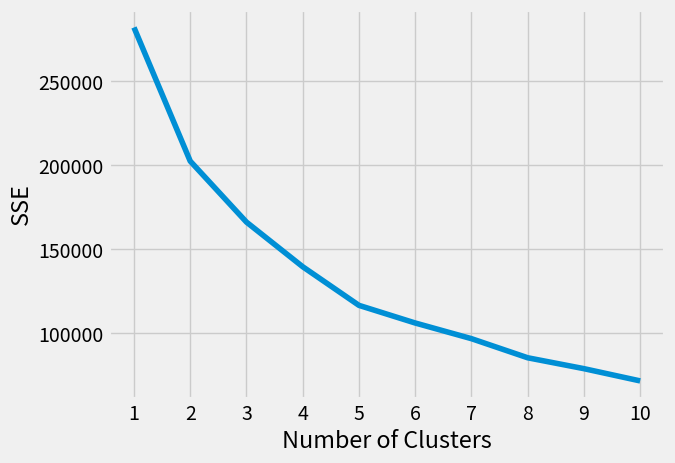

In [47]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}


sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  sse.append(kmeans.inertia_)
  

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [48]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

In [49]:
K = 4  


kmeans = KMeans(n_clusters=K, random_state=42)

kmeans.fit(X)

labels = kmeans.labels_ 

cluster_centers = kmeans.cluster_centers_  

# 打印每個樣本的群集標籤
print("Cluster Labels:")
print(labels)

# 打印每個群集的中心
print("Cluster Centers:")
print(cluster_centers)

Cluster Labels:
[0 0 0 ... 0 0 0]
Cluster Centers:
[[ 6.75481944e-01  3.46673907e-01  3.63127885e-01  2.72603856e-01
   7.52647298e-02  5.19304914e-01  2.26880261e-01  5.97339126e-04
   2.00577402e-18  8.90578333e-03  5.43035569e-05  1.42221015e-01
   3.71436329e-02  8.36274776e-03  2.71517784e-04  4.88188976e-02
   5.43035569e-05  2.98669563e-03  1.39560141e-02  8.03692642e-03
   9.39451534e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.66711920e-02  1.57480315e-03  5.43035569e-05
   1.62910671e-04  9.39451534e-03  8.03692642e-03]
 [ 1.10714286e+01  0.00000000e+00  3.57142857e-02  2.35714286e+00
   1.38777878e-17  4.36785714e+01  3.60714286e+00  3.57142857e-02
   3.57142857e-02  3.89285714e+00  7.14285714e-02  8.92857143e-01
   7.14285714e-02  2.32142857e+00  0.00000000e+00  2.85714286e-01
   0.00000000e+00  0.00000000e+00  3.46944695e-18  1.73472348e-18
   1.53571429e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  7.14285714e-02  0.000

c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [50]:
positive_clinic['cluster'] = labels

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_20188\3932318783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_clinic['cluster'] = labels


In [51]:
positive_clinic.query('positive_medical_staff_count > 30').head()

,機構代碼,機構名稱,權屬別,型態別,縣市_鄉鎮市區,電話,地址,診療科別,醫師,中醫師,牙醫師,藥師,藥劑生,護理師,護士,助產士,助產師,醫事檢驗師,醫事檢驗生,鑲牙生,中藥員,齒模員,接骨員,物理治療師,職能治療師,醫事放射師,醫事放射士,物理治療生,職能治療生,呼吸治療師,諮商心理師,臨床心理師,營養師,語言治療師,牙體技術師,聽力師,牙體技術生,驗光師,驗光生,緯度_醫療,經度_醫療,縣市,positive_medical_staff_count,cluster
6778,3543021837,立安診所,私立西醫診所,西醫專科診所,屏東縣_潮州鎮,08-7898711,屏東縣潮州鎮長興路2之7號,內科_,5,0,0,1,0,21,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.551309,120.543777,屏東縣,33,2
6912,3541312415,顏大翔內科診所,私立西醫診所,西醫診所,台南市_永康區,06-2730320,台南市永康區崑山里大灣路868號,內科_,3,0,0,1,0,27,2,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22.999858,120.256497,台南市,37,1
6914,3541312488,昕安內科診所,私立西醫診所,西醫診所,台南市_永康區,06-2725237,台南市永康區北灣里永大路二段1010號,內科_,3,0,0,1,0,22,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.017459,120.262976,台南市,31,2
7057,3541280301,懷仁內科診所,私立西醫診所,西醫診所,台南市_歸仁區,06-2303995,台南市歸仁區歸仁里中山路一段530號,內科_,6,0,0,1,0,24,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.966688,120.295754,台南市,42,2
7115,3542022143,安泰診所,私立西醫診所,西醫專科診所,高雄市_岡山區,6233500,高雄市岡山區岡山路434號,內科_,3,0,0,2,0,28,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.796094,120.295749,高雄市,35,1


In [52]:
positive_clinic  = positive_clinic.loc[:, ['縣市', '縣市_鄉鎮市區', '緯度_醫療', '經度_醫療', 'cluster', 'positive_medical_staff_count']]

In [53]:
positive_clinic

,縣市,縣市_鄉鎮市區,緯度_醫療,經度_醫療,cluster,positive_medical_staff_count
0,新北市,新北市_土城區,24.981607,121.459510,0,2
1,新北市,新北市_三峽區,24.936038,121.367128,0,1
2,新北市,新北市_三峽區,24.929320,121.374191,0,3
3,新北市,新北市_三峽區,24.935468,121.373238,0,6
4,新北市,新北市_淡水區,25.171935,121.440548,0,1
...,...,...,...,...,...,...
23297,台中市,台中市_北屯區,24.169972,120.679571,3,4
23298,新北市,新北市_板橋區,25.025674,121.465101,0,3
23299,台北市,台北市_大安區,25.036702,121.549338,0,5
23300,台北市,台北市_大安區,25.036773,121.549362,0,2


In [54]:
train = train.loc[:, ["ID", "縣市", "鄉鎮市區", "long",	"lat"]]

In [55]:
def deal_elementary(data: pd.DataFrame,  
                 elementary: pd.DataFrame,
                 weight_table: pd.DataFrame):
    # 創建一個空的DataFrame
    result_df = pd.DataFrame(columns=['ID', 'positive_medical_staff_count', '權重_醫療'])
    
    for city in data['縣市'].unique():
        print(f'正在處理{city}......')
        sub_data = data.loc[(data['縣市'] == city), ['ID', '縣市', '鄉鎮市區', 'lat', 'long']]
        merge_elementary = sub_data.merge(elementary, left_on=['縣市'], right_on='縣市')

        # 篩選距離小於1公里的站點
        merge_elementary['distance'] = merge_elementary.apply(lambda x: haversine(x['lat'], x['long'], x['緯度_醫療'], x['經度_醫療']), axis=1)

        # 篩選距離小於1公里的站點
        merge_elementary = merge_elementary.loc[merge_elementary['distance'] < 1.0]

        merge_elementary = merge_elementary.merge(weight_table, right_index=True, left_on='cluster')

        grouped = merge_elementary.groupby('ID').agg({'positive_medical_staff_count': 'sum', '權重_醫療': 'sum'}).reset_index()
        
        # 將計算結果附加到 result_df
        result_df = pd.concat([result_df, 
                            grouped],
                            ignore_index=True)
    return result_df

In [56]:
cluster_distribution = positive_clinic.groupby('cluster')['縣市'].count()
cluster_total_people_mean = positive_clinic.groupby('cluster')['positive_medical_staff_count'].mean()
merge_table = pd.concat([cluster_distribution, cluster_total_people_mean], axis=1)
merge_table.columns = ['集群包含數量', '診所總人數平均']

total = merge_table['診所總人數平均'].sum()
merge_table['權重_醫療'] = round(merge_table['診所總人數平均'] / total, 2)

In [57]:
merge_table

,集群包含數量,診所總人數平均,權重_醫療
cluster,,,
0,18415,2.796036,0.03
1,28,70.035714,0.77
2,1277,13.111198,0.14
3,1456,4.872940,0.05


In [58]:
'''
train_positive_clinic = deal_elementary(train, positive_clinic, merge_table)
# cluster_result.to_csv('train_elementary.csv', index=False)
train_positive_clinic
'''

正在處理台北市......
正在處理高雄市......


KeyboardInterrupt: 

In [ ]:
'''
test_positive_clinic = deal_elementary(test, positive_clinic, merge_table)
test_positive_clinic
'''

正在處理新北市......
正在處理台北市......
正在處理桃園市......
正在處理高雄市......
正在處理台中市......
正在處理新竹縣......
正在處理新竹市......
正在處理基隆市......
正在處理屏東縣......
正在處理台南市......
正在處理宜蘭縣......
正在處理苗栗縣......
正在處理嘉義市......
正在處理金門縣......
正在處理花蓮縣......
正在處理彰化縣......
正在處理雲林縣......


,ID,positive_medical_staff_count,權重_醫療
0,PU-1,97,0.93
1,PU-10,596,6.02
2,PU-1001,28,0.30
3,PU-1002,512,4.93
4,PU-1003,642,6.37
...,...,...,...
5789,PU-4024,98,1.20
5790,PU-4110,376,4.46
5791,PU-3753,59,0.58
5792,PU-4372,88,1.12


In [ ]:
#train_positive_clinic.to_csv("external_data_2/train_positive_clinic.csv", index=False)
#test_positive_clinic.to_csv("external_data_2/test_positive_clinic.csv", index=False)

* Positive clinv 的診所數量

In [62]:
def deal_bus_station(data: pd.DataFrame,
                     bus_data: pd.DataFrame):
    result_df = pd.DataFrame(columns=['ID', 'positive_clinic_數'])

    for city in data['縣市'].unique():
        sub_data = data.loc[(data['縣市'] == city), ['ID', '縣市', 'long', 'lat']]
        merge_bus = sub_data.merge(bus_data, on='縣市')
        merge_bus['distance'] = merge_bus.apply(lambda x: haversine(x['lat'], x['long'], x['緯度_醫療'], x['經度_醫療']), axis=1)
        
        merge_bus = merge_bus.loc[merge_bus['distance'] < 1.0]
        
        grouped = merge_bus.groupby('ID')['縣市'].count().reset_index()
        grouped.rename(columns={'縣市': 'positive_clinic_數'}, inplace=True)
        
        result_df = pd.concat([result_df, 
                            grouped],
                            ignore_index=True)

    
    return result_df

In [64]:
positive_clinic_數_train = deal_bus_station(train, positive_clinic)

In [65]:
positive_clinic_數_test = deal_bus_station(test, positive_clinic)

In [66]:
positive_clinic_數_train.to_csv("external_data_2/positive_clinic_數_train.csv", index=False)
positive_clinic_數_test.to_csv("external_data_2/positive_clinic_數_test.csv", index=False)